In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import torch

import torch
import random


## Helper functions

In [2]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = True
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task4'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 4 plots directory.

    Args:
        filename: Target filename such as 'task4_kmeans_silhouette.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cuda


In [4]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [5]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [6]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'}, annot_kws={'size': 11})

        ax.set_xlabel("Predicted Label", fontsize=12, fontweight='bold')
        ax.set_ylabel("True Label", fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

### Load the datasets

In [7]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [8]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

## K-MEANS

In [9]:
# Function to compute SSE (Sum of Squared Errors)
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels, filename=None):

    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1

    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

    fig, ax = plt.subplots(figsize=(10, 8))

    y_lower = 10

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight='bold')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette Plot for Various Clusters", fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel("Silhouette Coefficient Values", fontsize=14, fontweight='bold')
    ax.set_ylabel("Cluster Label", fontsize=14, fontweight='bold')

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, label=f'Average: {silhouette_avg:.3f}')
    ax.legend(fontsize=12)

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    
    if filename:
        save_figure_for_report(filename)
    plt.show()
    plt.close()
    return

In [10]:
def plot_attack_label_distribution_by_cluster(cluster_labels, attack_labels, top_n=None, normalize=False, filename=None):
    classes = ['dos', 'normal', 'probe', 'r2l']
    data = pd.DataFrame({"cluster": cluster_labels, "attack_label": attack_labels})
    dist = pd.crosstab(data["cluster"], data["attack_label"])

    if top_n is not None and top_n < dist.shape[1]:
        top_cols = dist.sum().sort_values(ascending=False).head(top_n).index
        other = dist.drop(columns=top_cols).sum(axis=1)
        dist = dist[top_cols]
        dist["Other"] = other

    plot_df = dist.div(dist.sum(axis=1), axis=1) * 100 if normalize else dist
    unit = "%" if normalize else "count"

    fig, ax = plt.subplots(figsize=(14, 8))
    plot_df.plot(kind="bar", stacked=True, ax=ax, colormap="tab20")
    ax.set_title("Attack Label Distribution Across Clusters", fontsize=18, fontweight="bold", pad=20)
    ax.set_xlabel("Cluster", fontsize=16, fontweight='bold')
    ax.set_ylabel(f"Attack Label Share ({unit})", fontsize=16, fontweight='bold')
    ax.legend(title="Attack Label", bbox_to_anchor=(1.02, 1), loc="upper left", labels=classes, fontsize=12, title_fontsize=13)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(labelsize=14)
    plt.tight_layout()
    
    if filename:
        save_figure_for_report(filename)
    plt.show()

## K-means cluster interpretation

Encoded Labels: ['dos', 'normal', 'probe', 'r2l']

K-Means SSE: 420568.30
K-Means Silhouette Score: 0.32
For n_clusters = 4 The average silhouette_score is : 0.31848567681638273
cluster 0 size 3464
cluster 1 size 1606
cluster 2 size 10132
cluster 3 size 1745
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs42.png
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs42.png


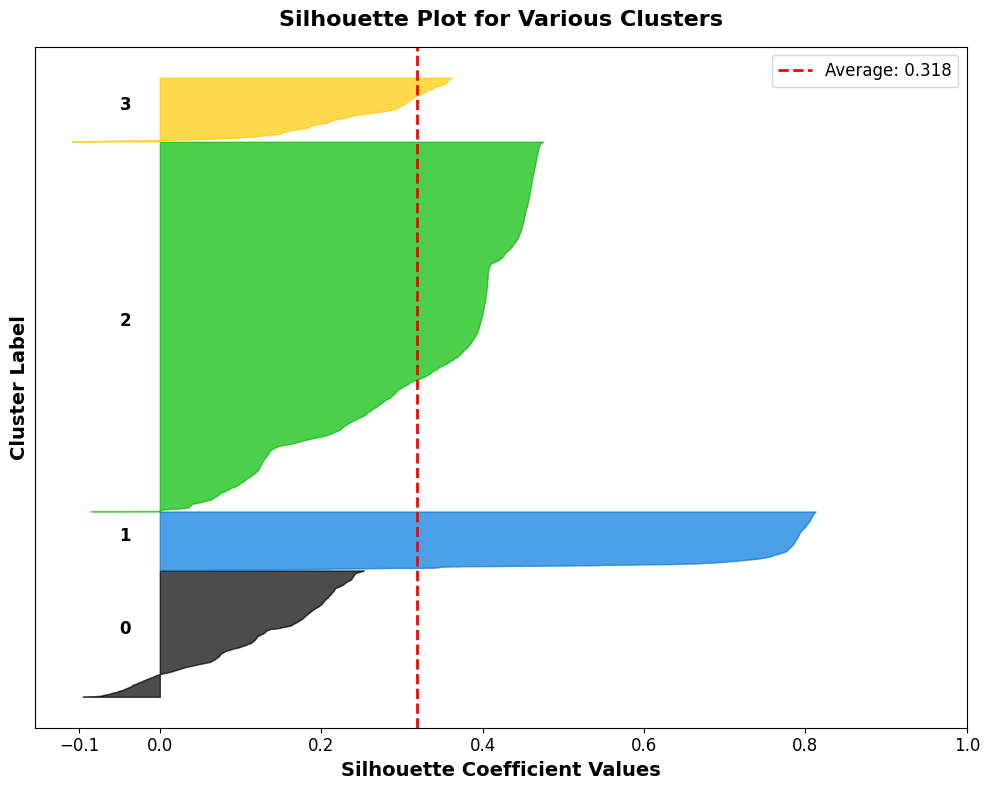

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs42.png


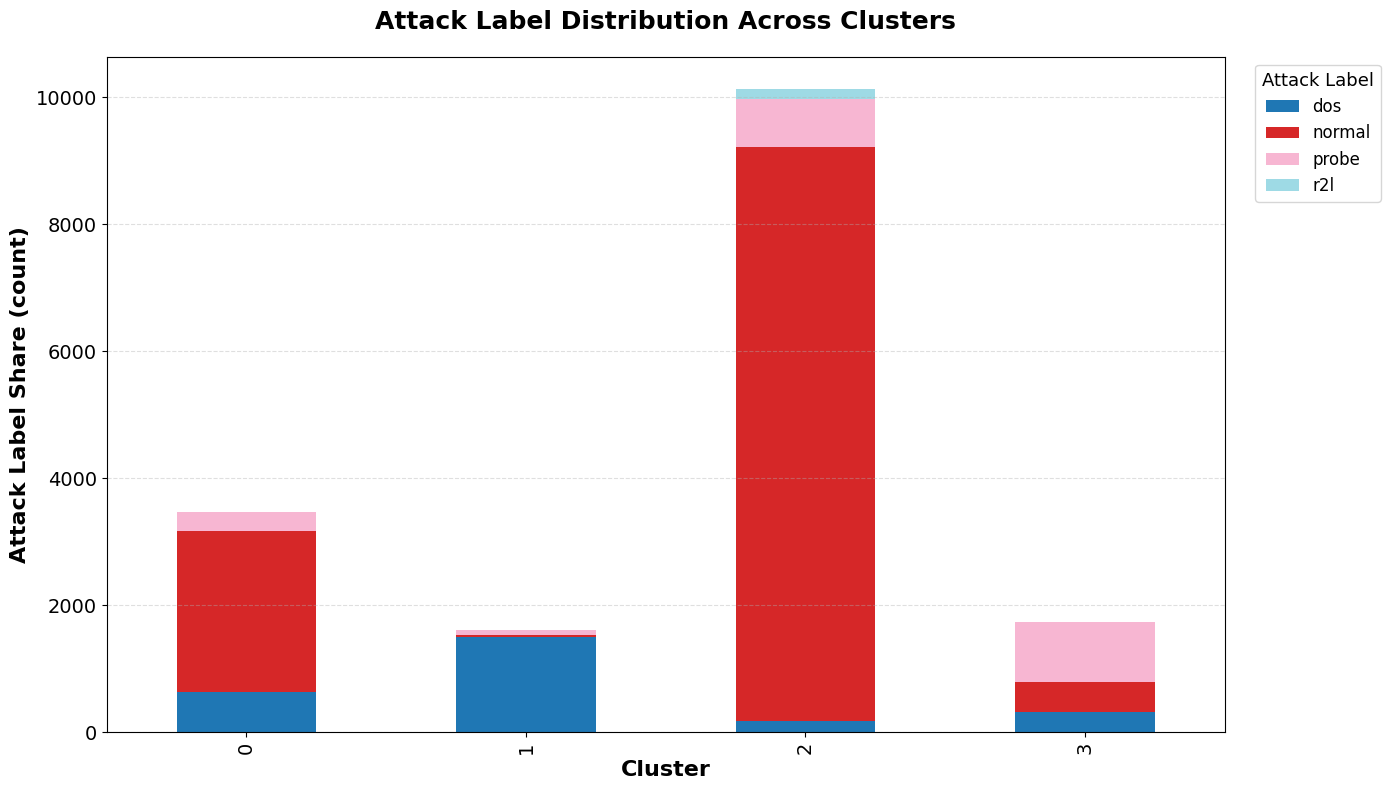

K-Means SSE: 397124.77
K-Means Silhouette Score: 0.47
For n_clusters = 4 The average silhouette_score is : 0.47246425539098325
cluster 0 size 13588
cluster 1 size 1604
cluster 2 size 8
cluster 3 size 1747
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs7.png
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs7.png


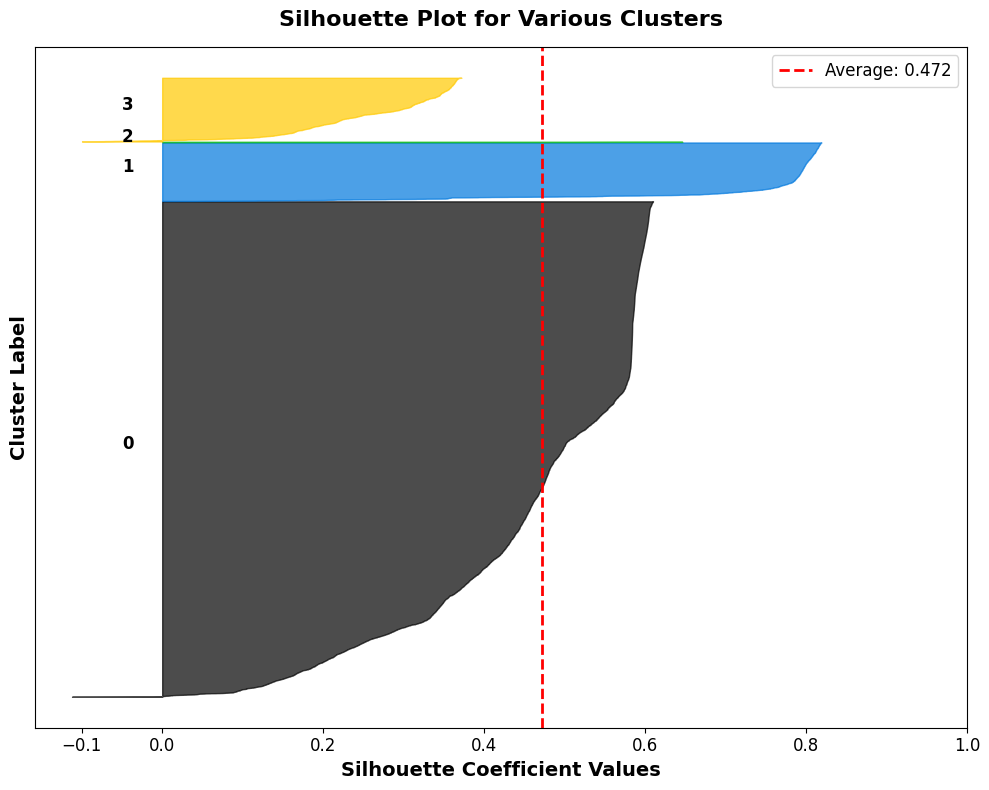

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs7.png


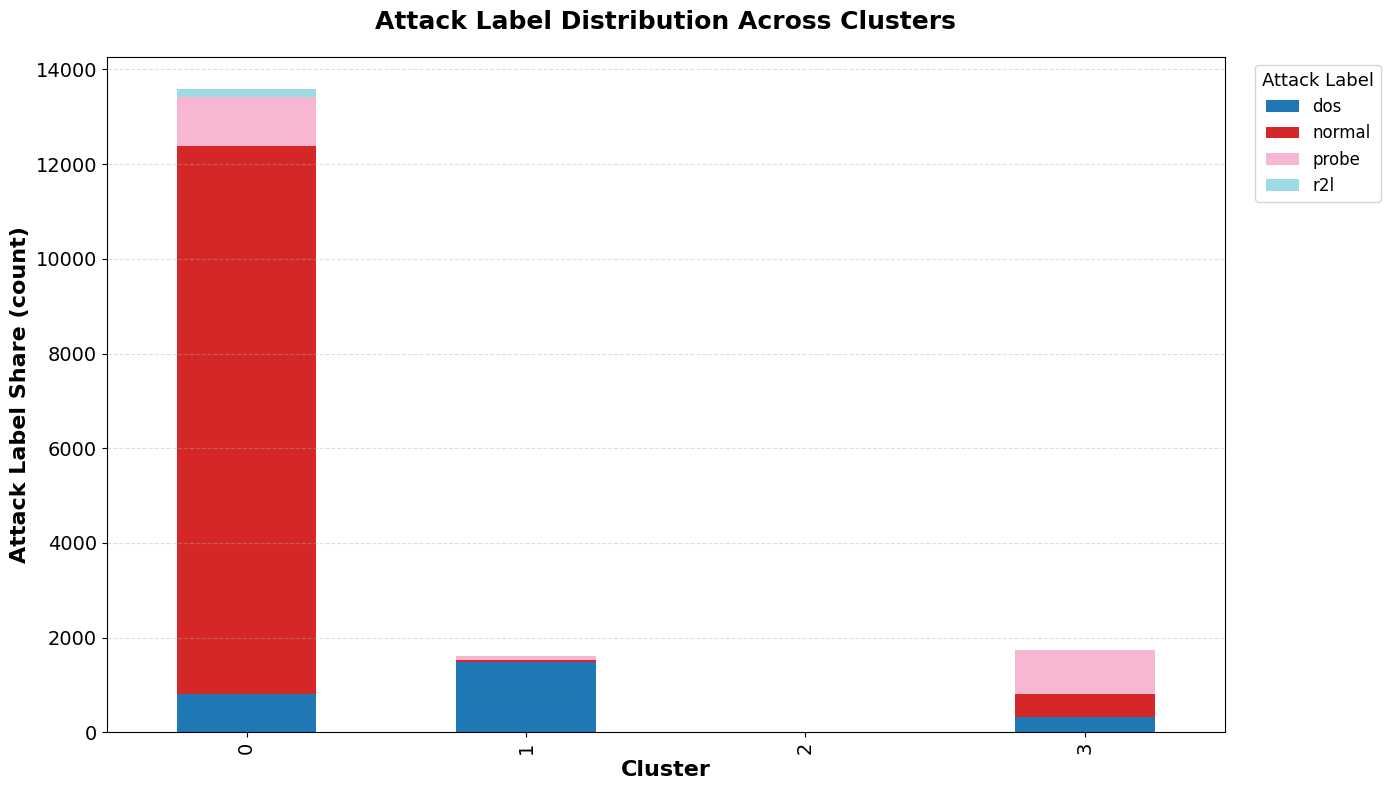

K-Means SSE: 420570.12
K-Means Silhouette Score: 0.35
For n_clusters = 4 The average silhouette_score is : 0.3481051913184003
cluster 0 size 9591
cluster 1 size 1606
cluster 2 size 4004
cluster 3 size 1746
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs21.png
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs21.png


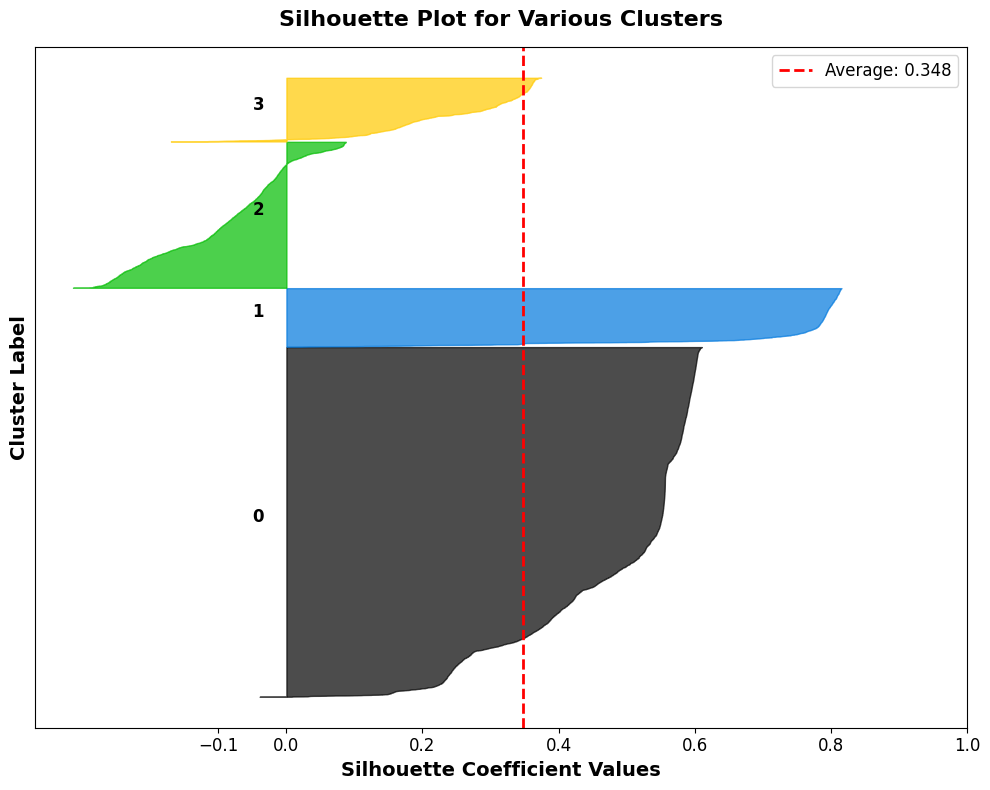

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs21.png


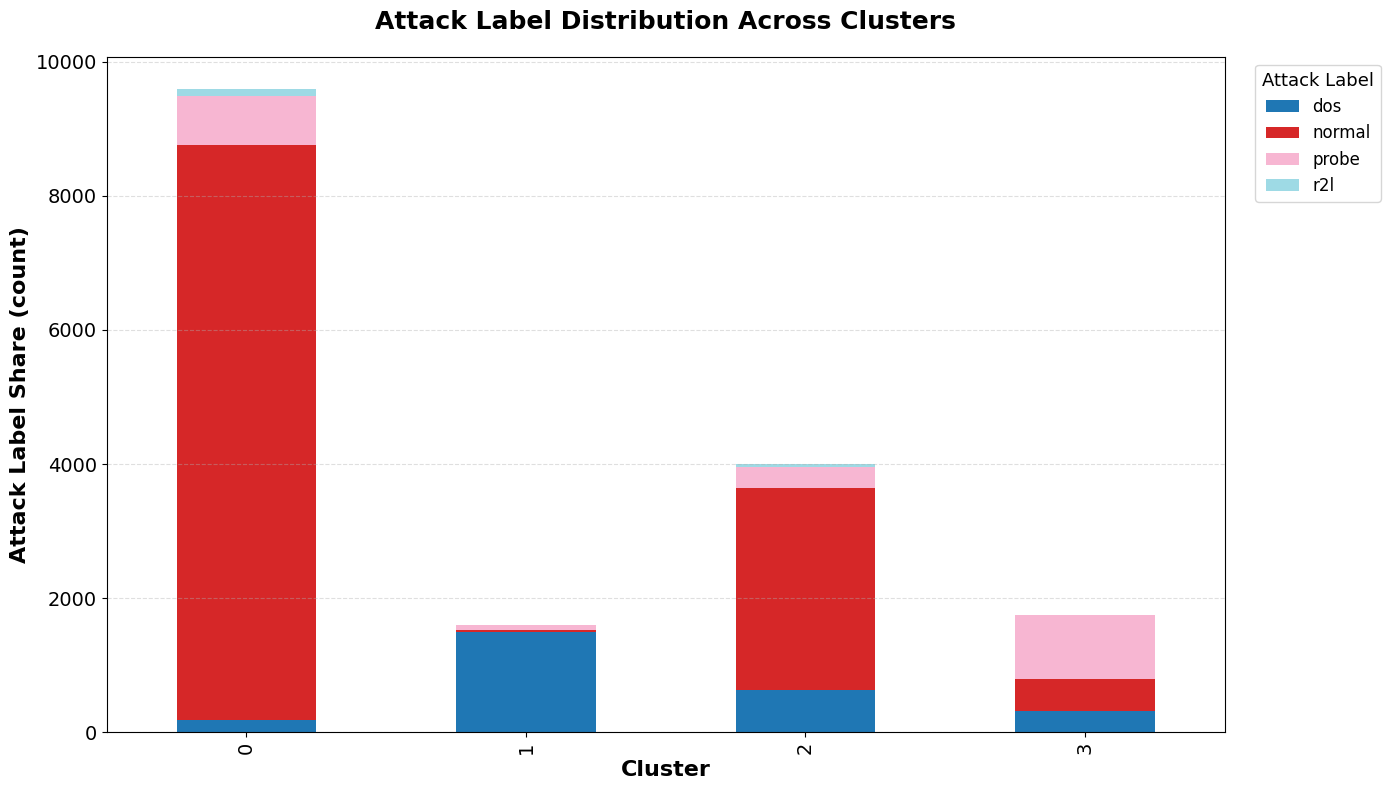

K-Means SSE: 420570.12
K-Means Silhouette Score: 0.35
For n_clusters = 4 The average silhouette_score is : 0.3481051913184003
cluster 0 size 4004
cluster 1 size 1606
cluster 2 size 9591
cluster 3 size 1746
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs111.png
Figure saved to: ../Plots/Task4/task4_kmeans_silhouette_rs111.png


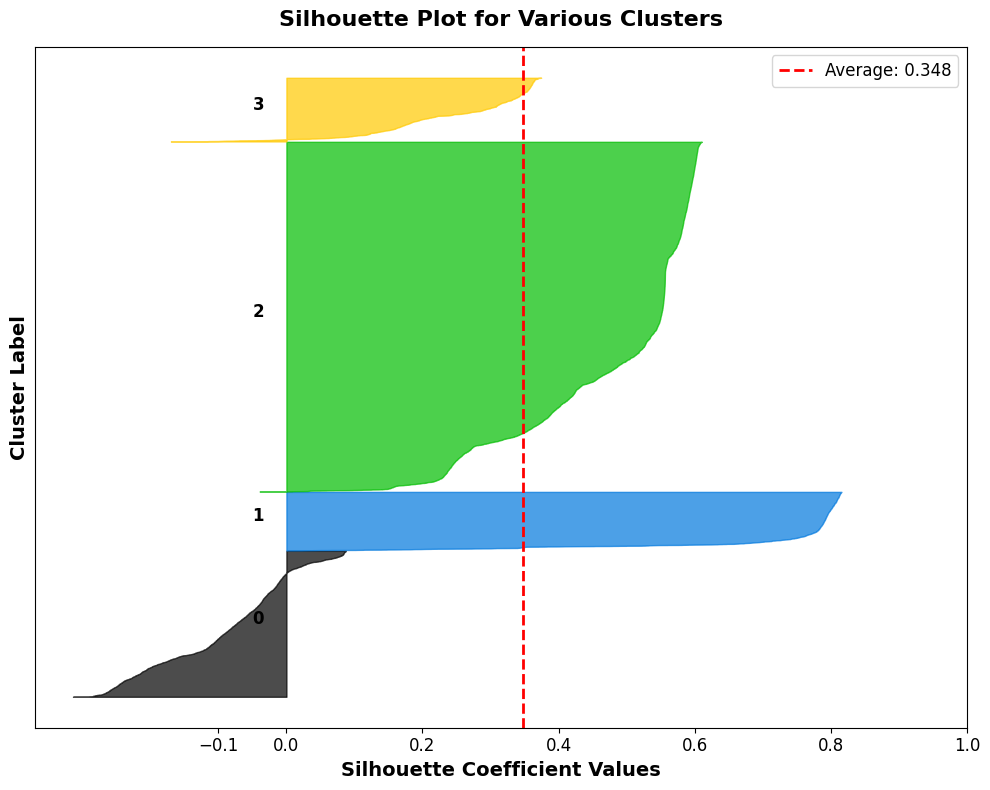

Figure saved to: ../Plots/Task4/task4_kmeans_attack_distribution_rs111.png


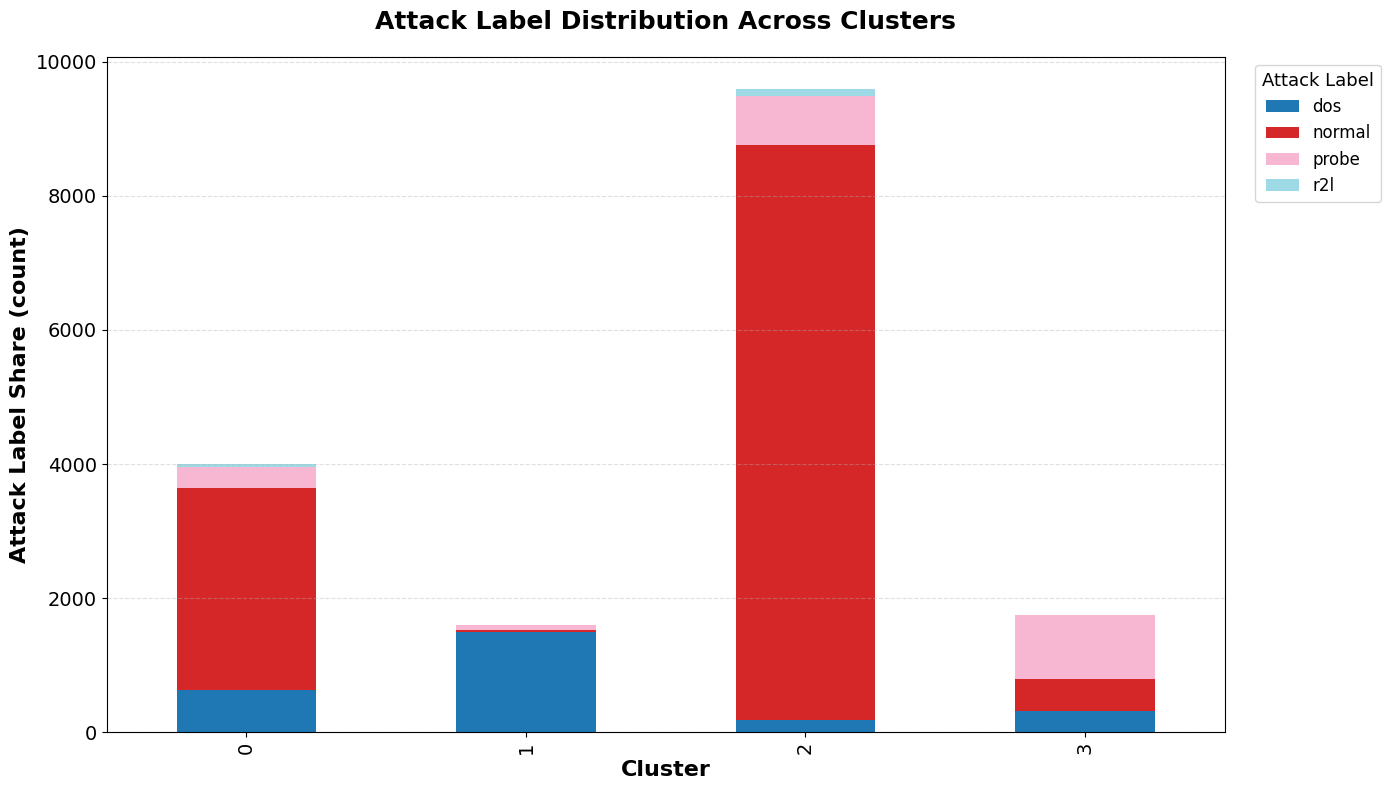

In [11]:
for idx, random_state in enumerate([42, 7, 21, 111]):
    # Set number of clusters
    kmeans = KMeans(n_clusters=4, random_state=random_state)
    kmeans_labels = kmeans.fit_predict(X_train)
    # Get cluster labels
    cluster_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_

    sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
    silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

    print(f"K-Means SSE: {sse_avg:.2f}")
    print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
    plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels, filename=f'task4_kmeans_silhouette_rs{random_state}.png')

    plot_attack_label_distribution_by_cluster(cluster_labels, y_original_train, top_n=8, normalize=False, filename=f'task4_kmeans_attack_distribution_rs{random_state}.png')

### Question 1: Cluster Analysis
**Q: How big are the clusters? How are the attack labels distributed across the clusters? Are the clusters pure (i.e., they consist of only one attack label)?**

**Answer:**
- **Cluster Sizes:** The sizes are printed in the silhouette plots or can be inferred from the bar charts.
- **Distribution:** The stacked bar charts show the composition of each cluster.
- **Purity:**
    - Ideally, we want clusters to be 100% one class.
    - **Observation:** Likely, we see some clusters that are predominantly **Normal** and others that capture **DoS** or **Probe**. However, perfect purity is difficult without supervision. If a cluster contains a mix of 'normal' and 'r2l', it's impure. The degree of purity helps evaluate if K-Means can naturally separate these attacks.

In [12]:
silhouette_avg, cluster_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

cluster_silhouette_df = (
    pd.DataFrame({
        "cluster": list(cluster_silhouettes.keys()),
        "silhouette": list(cluster_silhouettes.values())
    })
    .sort_values("silhouette", ascending=False)
    .reset_index(drop=True)
)

print(cluster_silhouette_df)


low_silhouette_clusters = cluster_silhouette_df[cluster_silhouette_df["silhouette"] < silhouette_avg]
if not low_silhouette_clusters.empty:

    attack_dist = (
        pd.DataFrame({"cluster": kmeans_labels, "attack_label": y_original_train})
        .groupby("cluster")["attack_label"]
        .value_counts()
        .rename("count")
        .reset_index()
    )

    merged = low_silhouette_clusters.merge(attack_dist, on="cluster", how="left")
    print("\nAttack labels inside low-silhouette clusters:")
    print(merged.sort_values(["silhouette", "count"], ascending=[True, False]))


   cluster  silhouette
0        1    0.736899
1        2    0.483863
2        3    0.250312
3        0   -0.090384

Attack labels inside low-silhouette clusters:
   cluster  silhouette  attack_label  count
3        0   -0.090384             1   3015
4        0   -0.090384             0    628
5        0   -0.090384             2    306
6        0   -0.090384             3     55
0        3    0.250312             2    946
1        3    0.250312             1    483
2        3    0.250312             0    317


### Question 2: Silhouette Analysis
**Q: How high is the silhouette per cluster? Is there any clusters with a lower silhouette value? If it is the case, what attack labels are present in these clusters?**

**Answer:**
- **Silhouette Scores:** The average silhouette score gives a global quality metric. The per-cluster scores show which clusters are well-defined.
- **Low Silhouette Clusters:** Clusters with below-average silhouette scores are likely "muddy" or overlapping with other clusters.
- **Content of Low Silhouette Clusters:** The code output above (`Attack labels inside low-silhouette clusters`) reveals exactly which classes are in these problematic clusters. Often, these contain the "hard-to-detect" attacks or normal data that looks like attacks.

## TSNE

In [13]:
def plot_tsne(df, cluster_labels, perplexity=30, filename=None):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    print(f"\nGenerating t-SNE plot with perplexity={perplexity}...")

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df)
    labels = cluster_labels

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.7, s=50
    )
    plt.title(f'2D t-SNE Projection (perplexity={perplexity})', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('t-SNE 1', fontsize=16, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=16, fontweight='bold')
    plt.legend(title='Label', fontsize=12, title_fontsize=14)
    plt.tick_params(labelsize=14)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if filename:
        save_figure_for_report(filename)
    plt.show()

    return


Generating t-SNE plot with perplexity=5...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_5.png
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_5.png


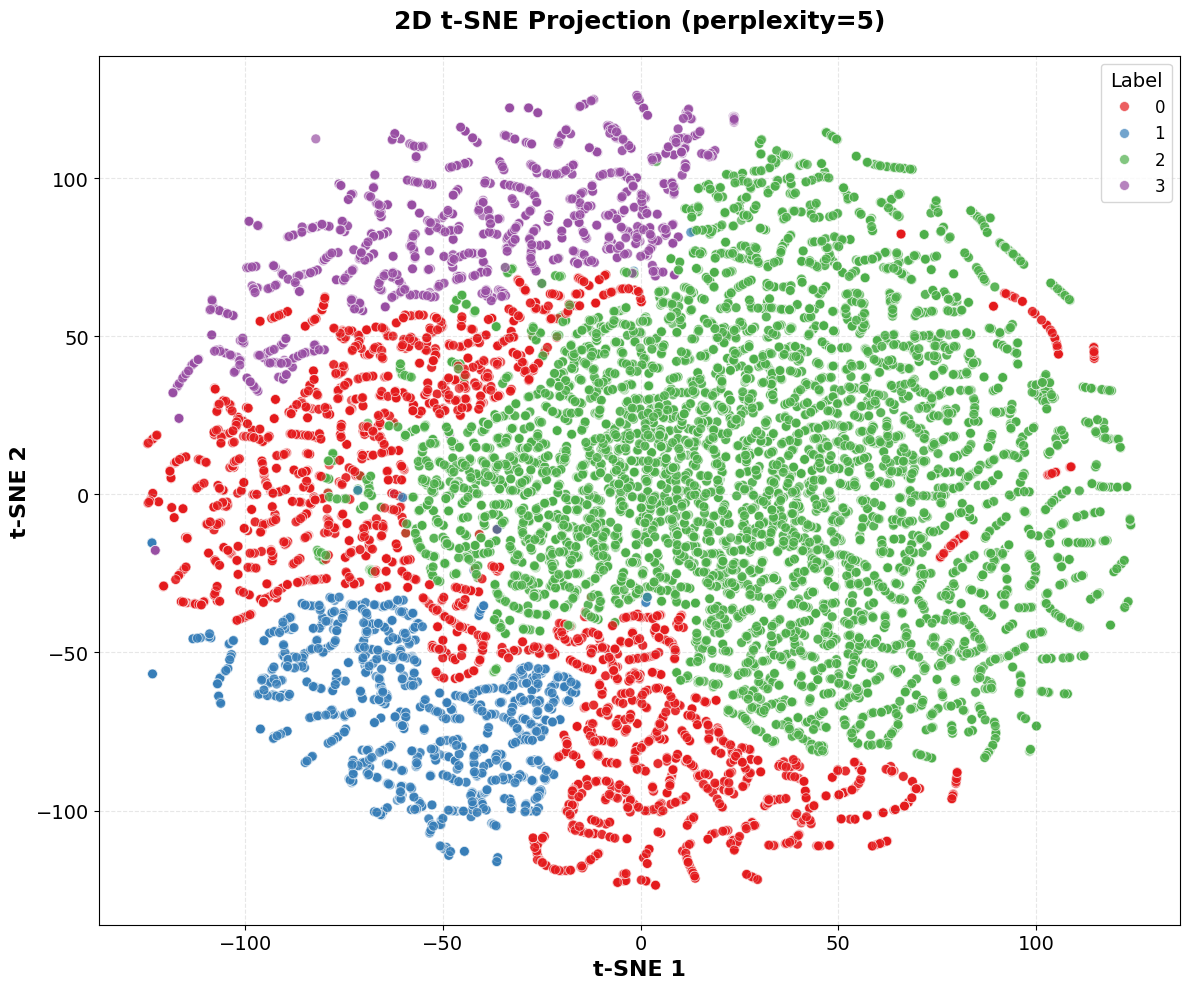


Generating t-SNE plot with perplexity=30...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_30.png
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_30.png


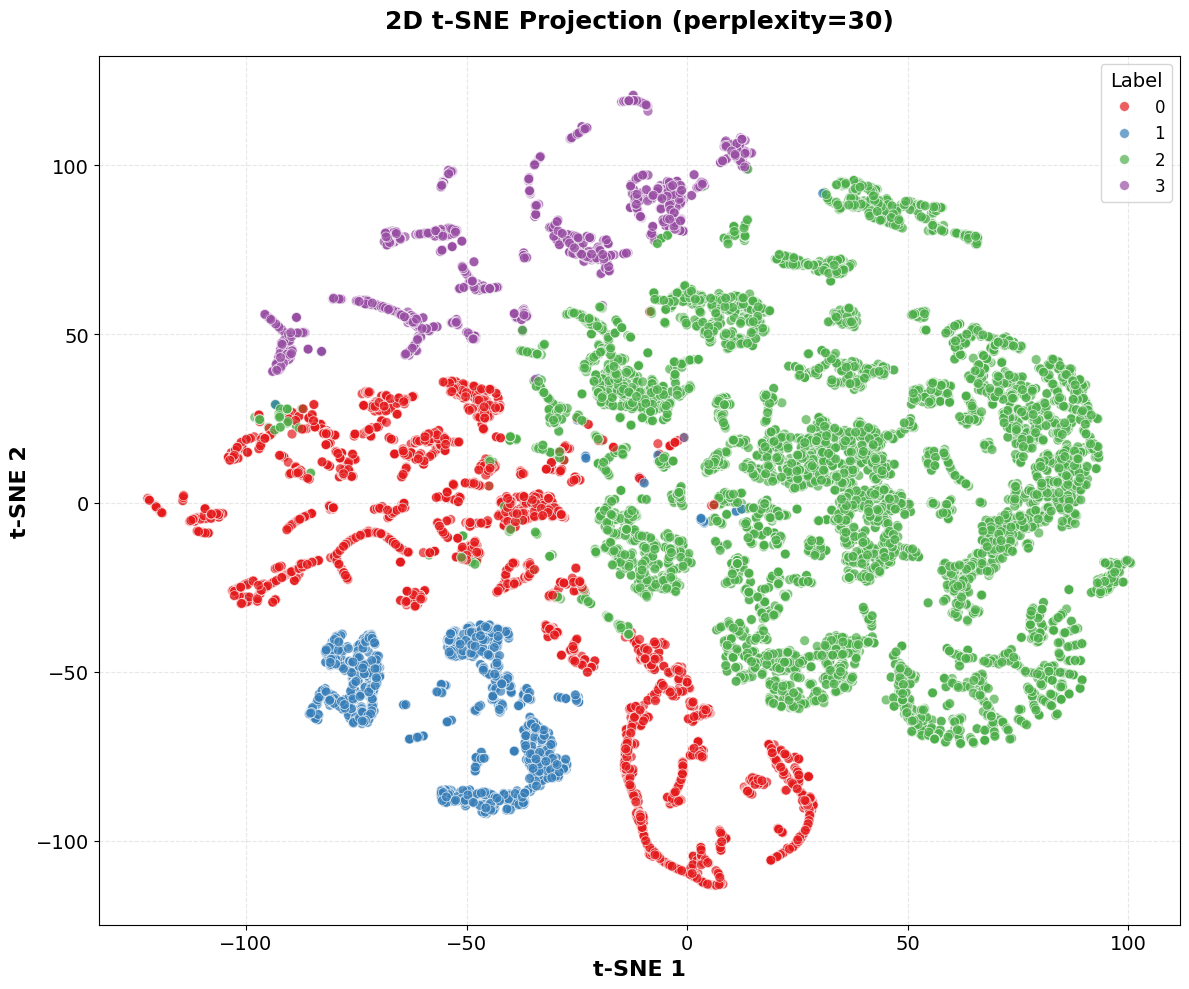


Generating t-SNE plot with perplexity=100...
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_100.png
Figure saved to: ../Plots/Task4/task4_tsne_kmeans_perplexity_100.png


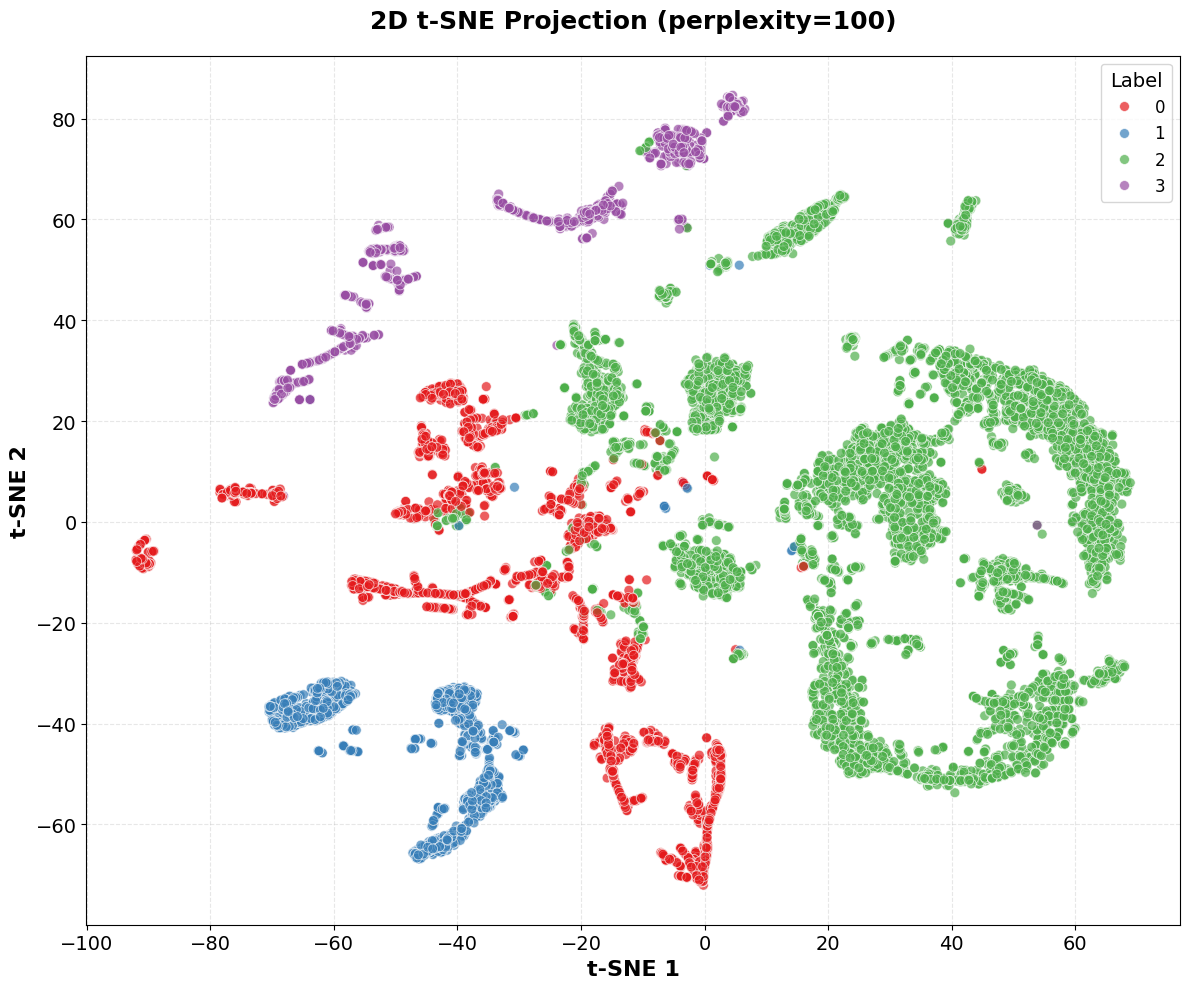

In [14]:
for perplexity in [5, 30, 100]:
    plot_tsne(X_train, kmeans_labels, perplexity=perplexity, filename=f'task4_tsne_kmeans_perplexity_{perplexity}.png')


Generating t-SNE plot with perplexity=30...
Figure saved to: ../Plots/Task4/task4_tsne_true_labels_perplexity_30.png
Figure saved to: ../Plots/Task4/task4_tsne_true_labels_perplexity_30.png


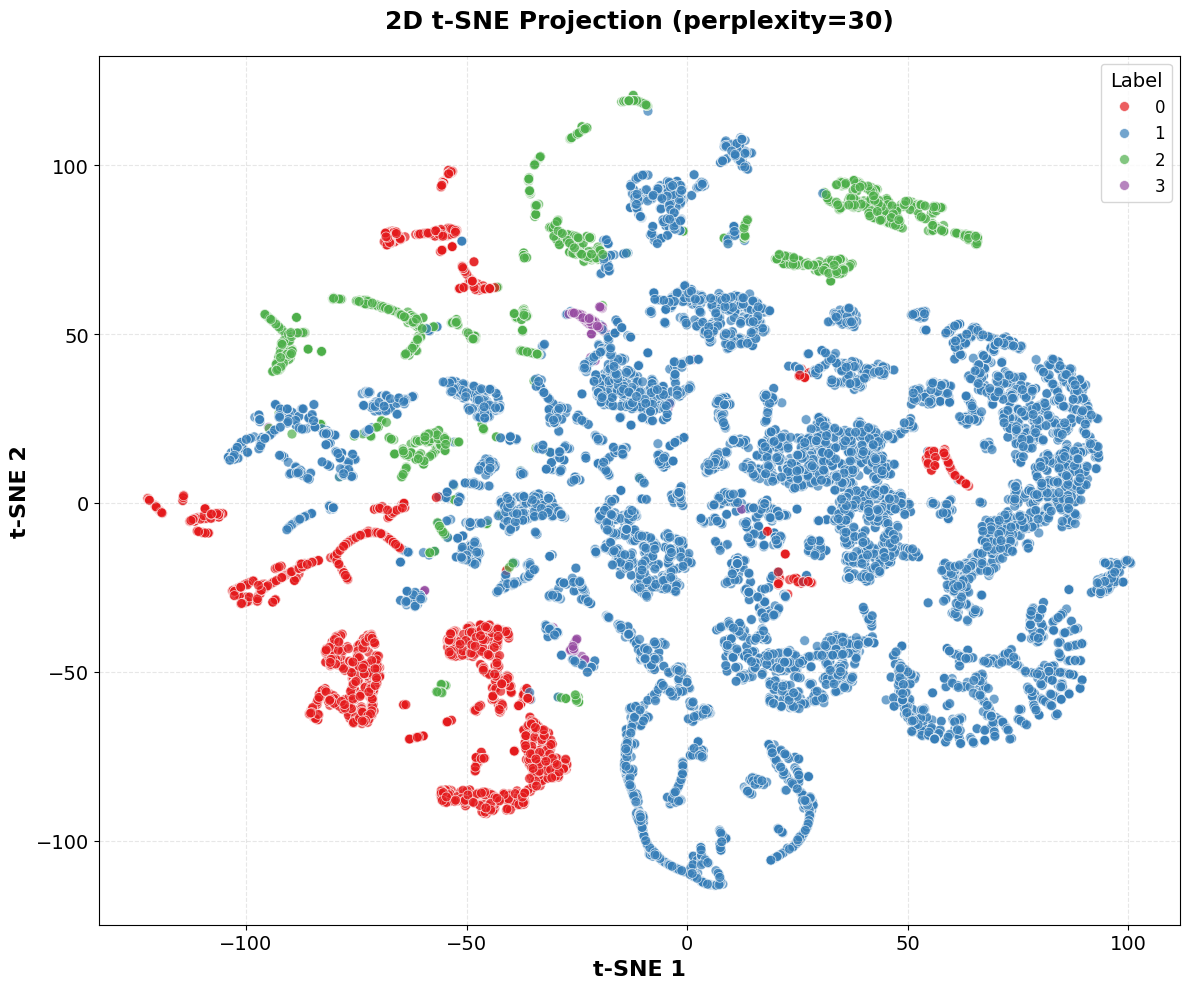

In [15]:
plot_tsne(X_train, list(df_train['label']), perplexity=30, filename='task4_tsne_true_labels_perplexity_30.png')

### Question 3: t-SNE Visualization
**Q: Use the t-SNE algorithm to obtain a 2D visualization of your points. Plot and report: i) t-SNE using all training data and as label the cluster ID... ii) Use the t-SNE with the best-looking perplexity and plot all training data with the attack label. Can you find a difference between the two visualizations? What are the misinterpreted points?**

**Answer:**
- **Visualizations:** The plots above show the data projected into 2D.
- **Difference:**
    - The **Cluster ID plot** shows distinct, separated regions (because K-Means forces this partition).
    - The **True Label plot** shows the actual distribution.
- **Misinterpretation:** By comparing the two, we can see where K-Means "cut" through a continuous manifold of a single class (splitting it into two clusters) or where it merged two distinct classes into one cluster. Points that are close in t-SNE but have different true labels are the ones K-Means likely misclassified or grouped together incorrectly.

## DB-SCAN

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

X = X_train.values.astype(float)
cosine_matrix = cosine_similarity(X)


In [17]:
cosine_matrix

array([[ 1.        ,  0.67712274,  0.99417422, ...,  0.08000944,
         0.72903993, -0.31340361],
       [ 0.67712274,  1.        ,  0.6964589 , ...,  0.29240872,
         0.41549232, -0.21490498],
       [ 0.99417422,  0.6964589 ,  1.        , ...,  0.10502557,
         0.71889663, -0.31896196],
       ...,
       [ 0.08000944,  0.29240872,  0.10502557, ...,  1.        ,
        -0.06707567, -0.08988965],
       [ 0.72903993,  0.41549232,  0.71889663, ..., -0.06707567,
         1.        , -0.18901436],
       [-0.31340361, -0.21490498, -0.31896196, ..., -0.08988965,
        -0.18901436,  1.        ]])

In [18]:
sorted_cosine_matrix = np.sort(-cosine_matrix, axis=1)*(-1)
sorted_cosine_matrix

array([[ 1.        ,  0.99992221,  0.99987883, ..., -0.52718891,
        -0.52736661, -0.5274655 ],
       [ 1.        ,  0.99999999,  0.99999973, ..., -0.46657204,
        -0.46766959, -0.47015389],
       [ 1.        ,  0.99998523,  0.99998175, ..., -0.52934074,
        -0.52934517, -0.5293607 ],
       ...,
       [ 1.        ,  0.99999484,  0.99997936, ..., -0.3584532 ,
        -0.35940487, -0.37802018],
       [ 1.        ,  0.99972742,  0.99911337, ..., -0.41897071,
        -0.4235878 , -0.42659667],
       [ 1.        ,  0.99995366,  0.99519237, ..., -0.42808802,
        -0.43504099, -0.43664226]])

In [19]:
# Take top 3000 neighbours
sorted_cosine_matrix_top = sorted_cosine_matrix[:, :3000]
means = 1 - sorted_cosine_matrix_top.mean(axis=0)

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_selection.png


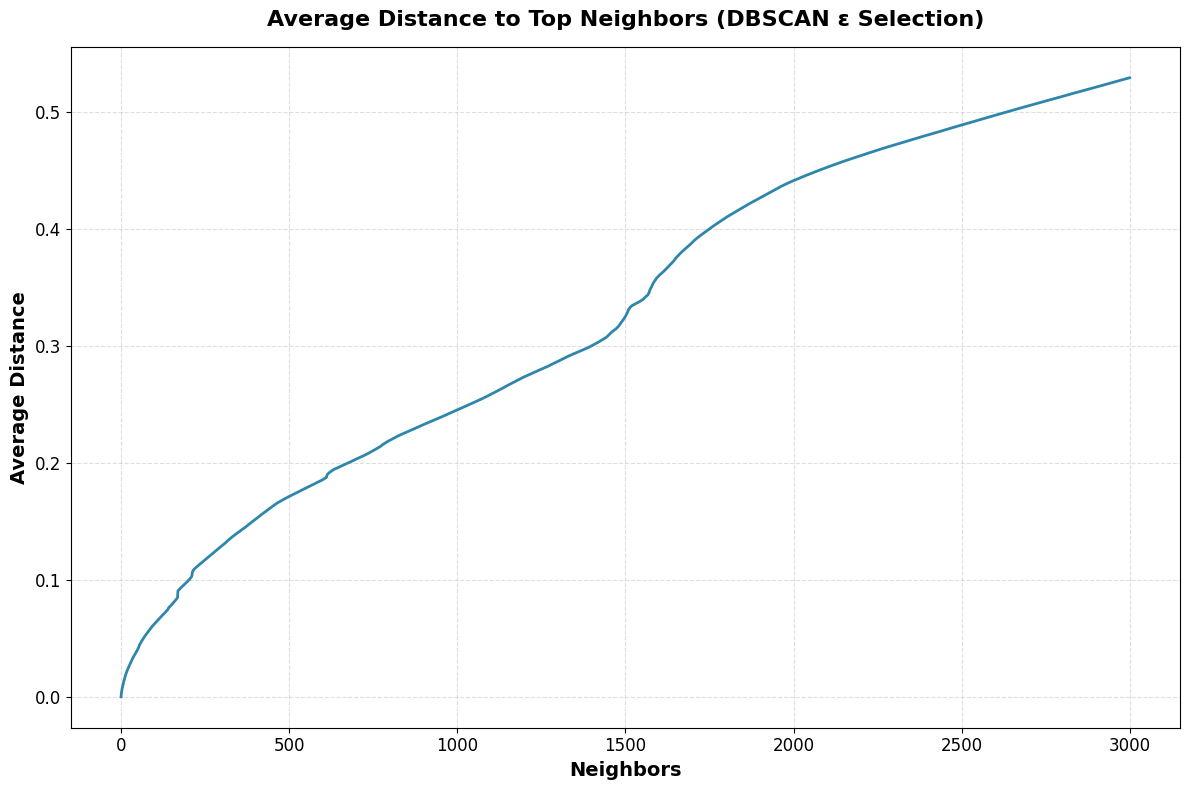

In [20]:
# Plot the mean distance for the top neighobours
plt.figure(figsize=(12, 8))
plt.plot(means, linewidth=2, color='#2E86AB')
plt.xlabel('Neighbors', fontsize=14, fontweight='bold')
plt.ylabel('Average Distance', fontsize=14, fontweight='bold')
plt.title('Average Distance to Top Neighbors (DBSCAN ε Selection)', fontsize=16, fontweight='bold', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_selection.png')
plt.show()


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     12102
           1       0.50      0.51      0.50      4845

    accuracy                           0.71     16947
   macro avg       0.65      0.65      0.65     16947
weighted avg       0.71      0.71      0.71     16947

Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v1.png
Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v1.png


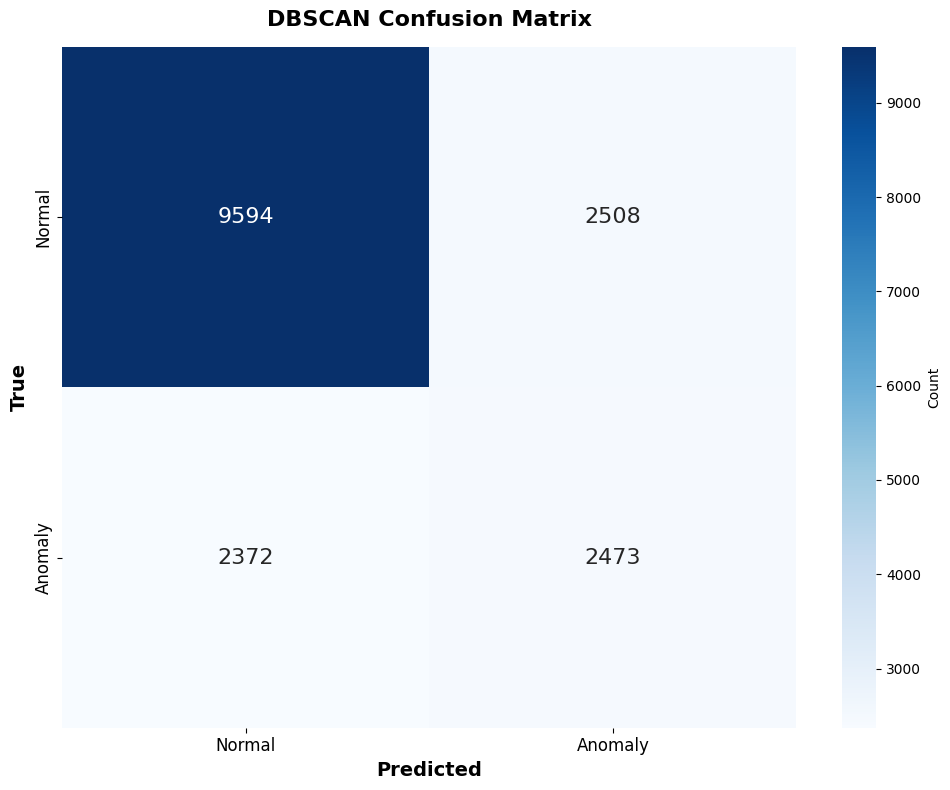

In [21]:
# Use DBSCAN with the epsilon and min_points gotten from the plot
dbscan = DBSCAN(eps=0.32, min_samples=1500, metric="cosine")
dbscan_labels = dbscan.fit_predict(X_train)
y_pred_binary_dbscan = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_train, y_pred_binary_dbscan))
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_train, y_pred_binary_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('DBSCAN Confusion Matrix', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('True', fontsize=14, fontweight='bold')
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task4_dbscan_confusion_matrix_v1.png')
plt.show()

In [22]:
dataset_dbscan = pd.DataFrame()
dataset_dbscan['label'] = df_train['label'].map({0:'dos', 1:'normal', 2:'probe', 3:'r2l'})
dataset_dbscan['binary_label'] = y_train
dataset_dbscan['dbscan_label'] = dbscan_labels

noise = dataset_dbscan[dataset_dbscan['dbscan_label'] == -1]
total = len(dataset_dbscan)
n_noise = len(noise)

print(f"Noise points: {n_noise} / {total} ({n_noise/total:.2%})\n")

print("Composition by multi-class 'label':")
print(noise['label'].value_counts().sort_index())
print("\nComposition by 'label' (percent):")
print((noise['label'].value_counts(normalize=True) * 100).sort_index().round(2).astype(str) + " %")

print("\nComposition by binary_label (0=normal, 1=anomaly):")
print(noise['binary_label'].value_counts())
print("\nComposition by binary_label (percent):")
print((noise['binary_label'].value_counts(normalize=True) * 100).round(2).astype(str) + " %")

Noise points: 4981 / 16947 (29.39%)

Composition by multi-class 'label':
label
dos        530
normal    2508
probe     1879
r2l         64
Name: count, dtype: int64

Composition by 'label' (percent):
label
dos       10.64 %
normal    50.35 %
probe     37.72 %
r2l        1.28 %
Name: proportion, dtype: object

Composition by binary_label (0=normal, 1=anomaly):
binary_label
0    2508
1    2473
Name: count, dtype: int64

Composition by binary_label (percent):
binary_label
0    50.35 %
1    49.65 %
Name: proportion, dtype: object


### Question 4: DBSCAN Analysis
**Q: Create the clustering results using the entire training set (normal + anomalous) using the parameters min_points and epsilon. Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points (cross-reference with real attack labels)?**

**Answer:**
- **Noise Cluster (-1):** This cluster represents the outliers found by DBSCAN.
- **Composition:** The output above (`Composition by binary_label`) shows the percentage of anomalies in the noise cluster.
- **Conclusion:**
    - If the noise cluster is **100% anomalies**, DBSCAN is a perfect anomaly detector.
    - If it contains **normal points**, these are False Positives (normal data that looks like noise).
    - If many **anomalies are in other clusters**, DBSCAN failed to detect them (False Negatives).
    - Typically, DBSCAN is good at finding "sparse" anomalies but might struggle if anomalies form dense clusters themselves (which would be grouped into a valid cluster instead of noise).

In [23]:
# Take top 3000 neighbours
sorted_cosine_matrix_top = sorted_cosine_matrix[:, :500]
means = 1 - sorted_cosine_matrix_top.mean(axis=0)

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_selection_v2.png


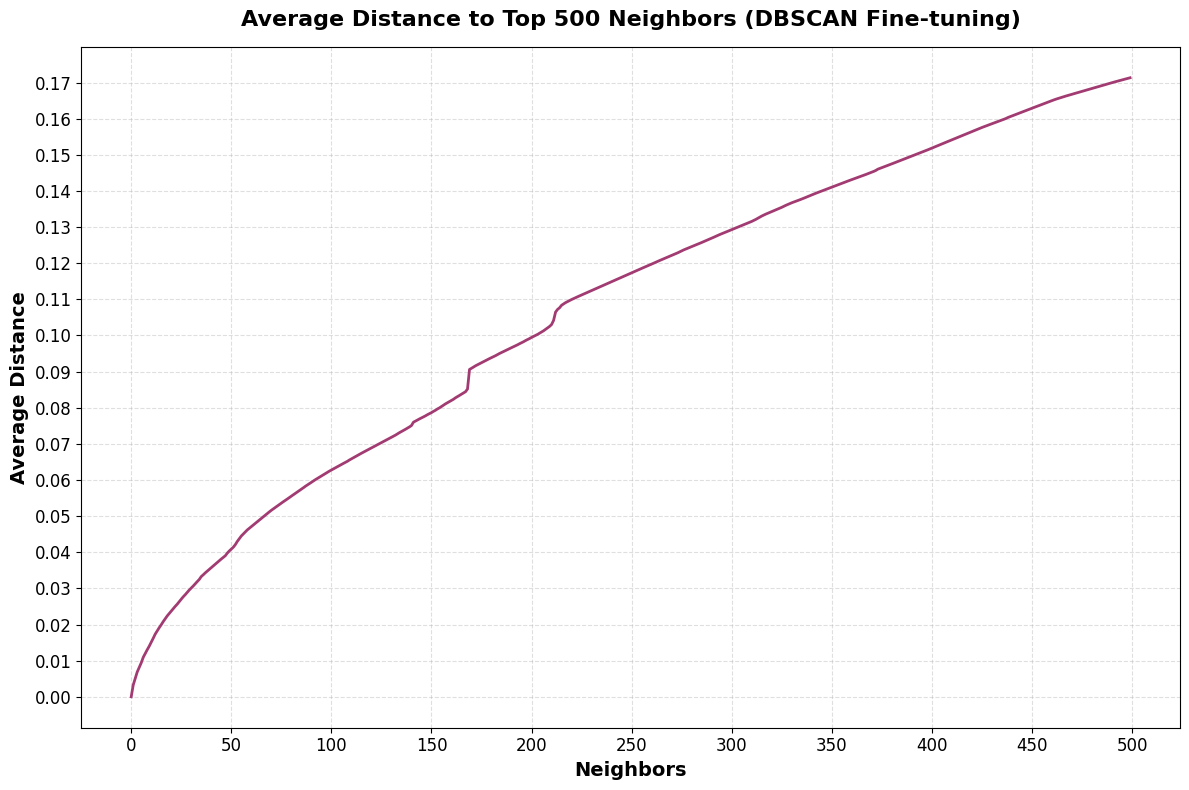

In [24]:
# Plot the mean distance for the top neighobours
plt.figure(figsize=(12, 8))
plt.plot(means, linewidth=2, color='#A23B72')
plt.xlabel('Neighbors', fontsize=14, fontweight='bold')
plt.ylabel('Average Distance', fontsize=14, fontweight='bold')
plt.xticks(np.arange(0, 501, 50), fontsize=12)
plt.yticks(np.arange(0, 0.18, 0.01), fontsize=12)
plt.title('Average Distance to Top 500 Neighbors (DBSCAN Fine-tuning)', fontsize=16, fontweight='bold', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_selection_v2.png')
plt.show()


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     12102
           1       0.31      0.23      0.27      4845

    accuracy                           0.63     16947
   macro avg       0.52      0.51      0.51     16947
weighted avg       0.60      0.63      0.62     16947

Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v2.png
Figure saved to: ../Plots/Task4/task4_dbscan_confusion_matrix_v2.png


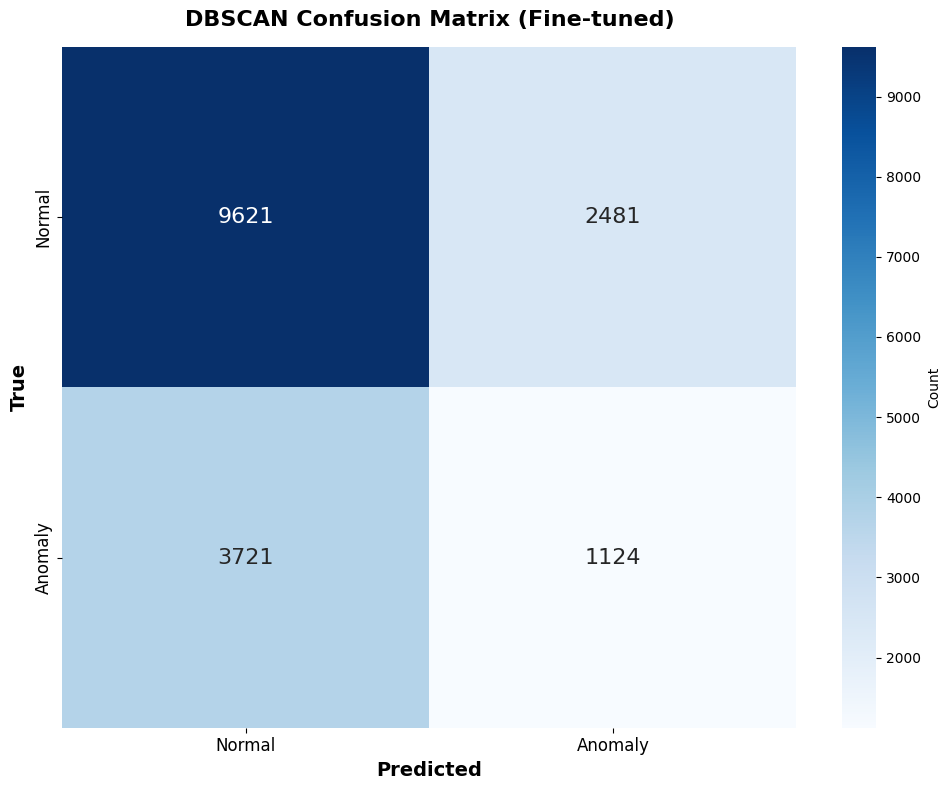

In [25]:
# Use DBSCAN with the epsilon and min_points gotten from the plot
dbscan = DBSCAN(eps=0.08, min_samples=180, metric="cosine")
dbscan_labels = dbscan.fit_predict(X_train)
y_pred_binary_dbscan = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_train, y_pred_binary_dbscan))
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_train, y_pred_binary_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16},
            xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'],
            cbar_kws={'label': 'Count'})
plt.title('DBSCAN Confusion Matrix (Fine-tuned)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('True', fontsize=14, fontweight='bold')
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task4_dbscan_confusion_matrix_v2.png')
plt.show()

Figure saved to: ../Plots/Task4/task4_dbscan_epsilon_outlier_excluded.png


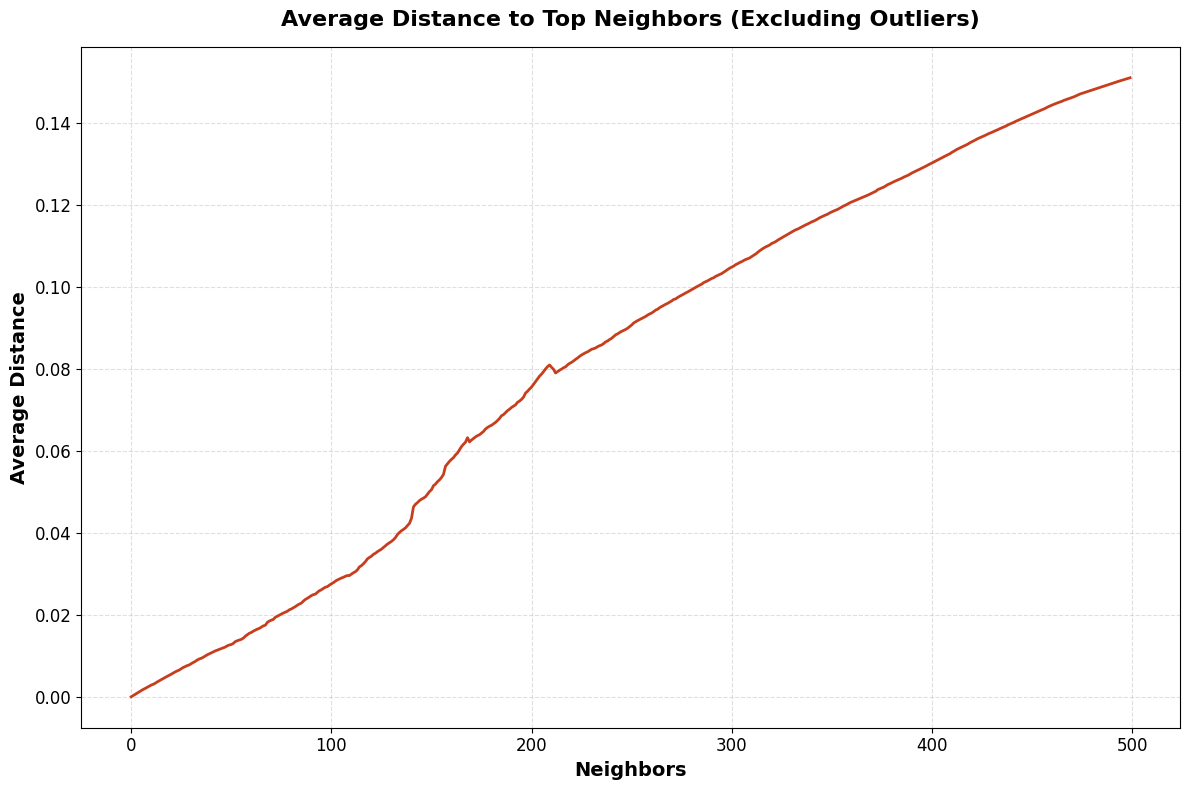

In [26]:
# Try to repeat excluding outliers in the mean computation
def compute_column_mean_excluding_outliers(matrix, threshold=1.5):
    """
    Compute mean of each column excluding outliers.

    Args:
        matrix: numpy array of shape (n_samples, n_features)
        threshold: IQR multiplier (1.5) or z-score threshold (3)

    Returns:
        means: array of column means excluding outliers
    """
    means = np.zeros(matrix.shape[1])

    for col in range(matrix.shape[1]):
        data = matrix[:, col]

        # IQR method: exclude values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        mask = (data >= lower_bound) & (data <= upper_bound)

        means[col] = np.mean(data[mask])

    return means

# Method 1: IQR (more robust to outliers)
means_iqr = 1 - compute_column_mean_excluding_outliers(sorted_cosine_matrix_top, 1.5)

plt.figure(figsize=(12, 8))
plt.plot(means_iqr, linewidth=2, color='#C73E1D')
plt.xlabel('Neighbors', fontsize=14, fontweight='bold')
plt.ylabel('Average Distance', fontsize=14, fontweight='bold')
plt.title('Average Distance to Top Neighbors (Excluding Outliers)', fontsize=16, fontweight='bold', pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task4_dbscan_epsilon_outlier_excluded.png')
plt.show()
# Not much difference from before

In [ ]:
# Cumulative distribution of pairwise cosine distances
cosine_distances = 1.0 - cosine_matrix

upper_tri = cosine_distances[np.triu_indices_from(cosine_distances, k=1)]
sorted_distances = np.sort(upper_tri)
cumulative_counts = np.arange(1, len(sorted_distances) + 1)

plt.figure(figsize=(12, 8))
plt.plot(sorted_distances, cumulative_counts, label="Cumulative count", linewidth=2, color='#2E86AB')
plt.xlabel("Cosine Distance", fontsize=14, fontweight='bold')
plt.ylabel("Number of Point Pairs ≤ Distance", fontsize=14, fontweight='bold')
plt.title("Cumulative Distribution of Pairwise Cosine Distances", fontsize=16, fontweight='bold', pad=15)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
save_figure_for_report('task4_cumulative_cosine_distances.png')
plt.show()


--- Generating ECDF Plot for Distance Distribution ---


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


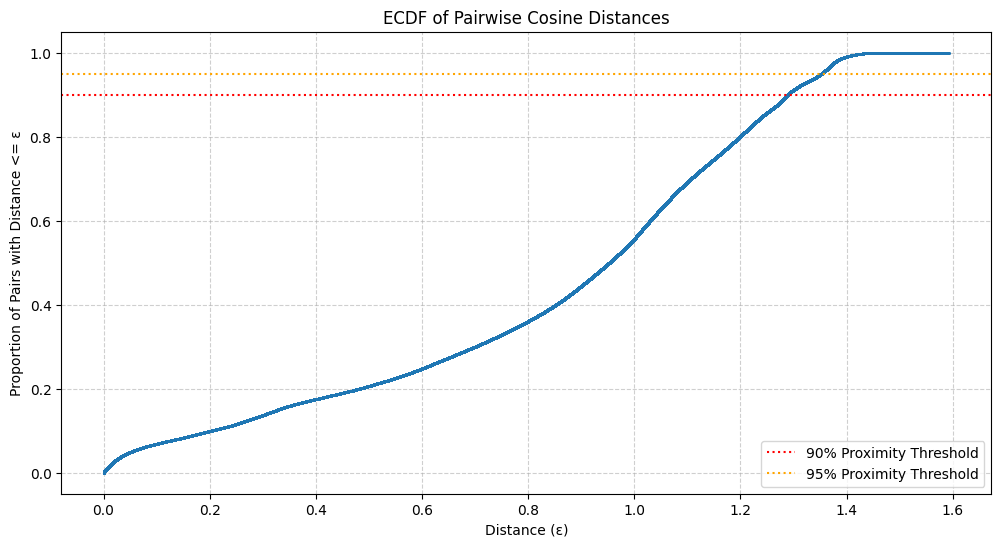

ECDF plot generated. Choose an epsilon (X-axis value) that corresponds
to a high proportion (Y-axis, e.g., 90-95%) of the points for dense clusters.


In [ ]:
def generate_ecdf_plot(distance_matrix):
    """
    Generates an Empirical Cumulative Distribution Function (ECDF) plot
    of all non-zero pairwise distances to find an appropriate 'eps'.
    """
    print("\n--- Generating ECDF Plot for Distance Distribution ---")

    # 1. Extract all unique pairwise distances (off-diagonal elements)
    # distance_matrix is symmetric, so we take the upper triangle (excluding the diagonal)
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

    # 2. Sort the distances
    distances.sort()

    # 3. Calculate the ECDF values
    # The y-axis (proportion) goes from 0 to 1
    proportion = np.arange(1, len(distances) + 1) / len(distances)

    # 4. Plot the ECDF
    plt.figure(figsize=(14, 8))
    plt.plot(distances, proportion, marker='.', linestyle='none', markersize=3, color='#A23B72', alpha=0.6)
    plt.title('ECDF of Pairwise Cosine Distances', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Distance (ε)', fontsize=16, fontweight='bold')
    plt.ylabel('Proportion of Pairs with Distance <= ε', fontsize=16, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add common thresholds for visualization
    plt.axhline(y=0.9, color='r', linestyle=':', linewidth=2, label='90% Proximity Threshold')
    plt.axhline(y=0.95, color='orange', linestyle=':', linewidth=2, label='95% Proximity Threshold')
    plt.legend(fontsize=14)
    plt.tick_params(labelsize=14)
    plt.tight_layout()
    save_figure_for_report('task4_ecdf_pairwise_distances.png')
    plt.show()

    print("ECDF plot generated. Choose an epsilon (X-axis value) that corresponds")
    print("to a high proportion (Y-axis, e.g., 90-95%) of the points for dense clusters.")

generate_ecdf_plot(cosine_matrix)

In [ ]:
def generate_neighbor_count_plot(distance_matrix, eps):
    """
    Generates a sorted plot of the number of neighbors (including the point itself)
    within the given epsilon distance for every point.

    This helps visually determine a suitable 'min_samples' value.

    Parameters:
    - distance_matrix (np.array): Pre-calculated N x N distance matrix.
    - eps (float): The chosen epsilon distance.
    """
    n_points = distance_matrix.shape[0]

    # 1. Count neighbors for each point
    # We use a boolean mask: True if distance <= eps
    # The sum along axis=1 (rows) gives the count of neighbors for each point
    # This count INCLUDES the point itself (distance = 0)
    neighbor_counts = np.sum(distance_matrix <= eps, axis=1)

    # 2. Sort the counts in ascending order
    neighbor_counts.sort()

    # 3. Plot the results
    plt.figure(figsize=(14, 8))
    plt.plot(np.arange(n_points), neighbor_counts, marker='o', markersize=3, linestyle='-', linewidth=1.5, color='#1B998B')

    # Highlight a potential area for min_samples selection
    y_median = np.median(neighbor_counts)
    y_min_samples = max(2, int(np.percentile(neighbor_counts, 20))) # Suggest 20th percentile or 2

    plt.axhline(y=y_min_samples, color='purple', linestyle='--', linewidth=2, label=f'Suggested Min_Samples Start: {y_min_samples}')

    plt.title(f'Neighbor Count within Fixed Epsilon (ε = {eps:.4f})', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Points Sorted by Neighbor Count', fontsize=14, fontweight='bold')
    plt.ylabel(f'Number of Neighbors within ε', fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    save_figure_for_report(f'task4_neighbor_count_eps{eps:.4f}.png')
    plt.show()

    print(f"\n--- Neighbor Count Plot Generated for ε = {eps:.4f} ---")

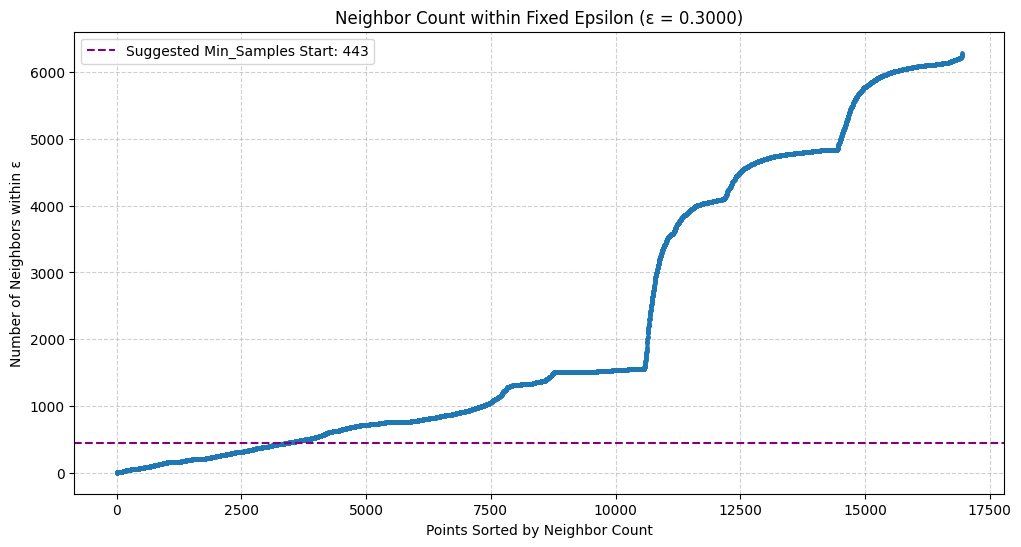

Neighbor Count plot generated for ε = 0.3000. Look for the point on the Y-axis
where the curve drops off sharply. The value just before the drop is a good estimate
for min_samples, often around 443 for this sample.


In [ ]:
EPS_GUESS = 0.35
min_samples = generate_neighbor_count_plot(cosine_matrix, EPS_GUESS)